In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
print("Tensor Flow version {}".format(tf.__version__))

Tensor Flow version 2.11.0


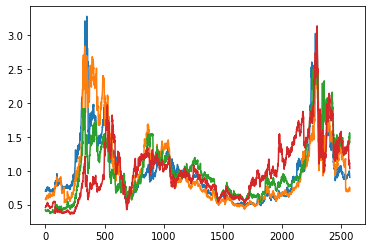

In [6]:
#To load data
datas = np.load("stock_revised.npz")
data = datas["data"]
TRAIN_LEN = 1500

#small scale#
'''TRAIN_LEN = 500
data = data[:, :600]
print data.shape'''
#small scale#


plt.figure()
plt.plot(data[0])
plt.plot(data[1])
plt.plot(data[2])
plt.plot(data[3])

In [10]:
CORR_DIM = 6
LEN = len(data[0])
xbat = data.shape[0]
xlen = data.shape[1]

Xs = np.zeros((int(xbat/CORR_DIM), xlen, CORR_DIM))

for i in range(int(xbat / CORR_DIM)):
    Xs[i,:,:] = np.transpose(data[6*i:6*(i+1), :])

print(Xs.shape)
X_train = Xs[:,:TRAIN_LEN,:]
X_test = Xs[:,:,:]

BATCH_NUM = xbat / CORR_DIM

(27, 2571, 6)


In [12]:
EMBED_DIM = 1
'''EMBED_DIM = 20
LEN = len(data[0])
TRAIN_LEN = 1500
BATCH_NUM = len(data)


X_raw = np.zeros([BATCH_NUM, LEN, 1])
X_raw[:, :,0] = data
print

xbat = X_raw.shape[0]
xlen = X_raw.shape[1]
xwid = X_raw.shape[2]
newlen = xlen - EMBED_DIM + 1
newwid = xwid * EMBED_DIM
Xs = np.zeros((xbat, newlen, newwid))
#print X_test_raw.shape
for i in range(EMBED_DIM):
    Xs[:, :, i*xwid:(i+1)*xwid] = X_raw[:, i:i+newlen, :]

#print Xs
X_train = Xs[:,:TRAIN_LEN,:]
X_test = Xs[:,:,:]'''
print(X_train.shape)
print(X_test.shape)

(27, 1500, 6)
(27, 2571, 6)


In [13]:
N_x = CORR_DIM
N_hi = [10,10]
N_z = 2
N_hg = [10,10]
N_o = N_x
CORR_RANK = 0

#2:
#NLL_train = -1.81017580088
#NLL_test = -1.60838533647
#1:
#NLL_train = -2.28424248576
#NLL_test = -2.20789705344
#0:
#NLL_train = -2.57541425927
#NLL_test = -2.3767351664
#NLL_train = -2.13588618534
#NLL_test = -2.11480672778
#NLL_train = -2.14512410261
#NLL_test = -2.10953426166


#T = TRAIN_LEN
M = BATCH_NUM
L = 10
LEARNING_RATE = 0.001

DROPOUT = 0

Dtype = tf.float32

In [16]:
#tf.reset_default_graph()
xs = tf.empty(Dtype, [M, None, N_x])
rv = tf.empty(Dtype, [M, L, None, N_z])
outs = xs[:, :, N_x-N_o:N_x]

eps = 1e-5

def weights(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def biases(shape):
    initial = tf.constant(0.0, shape=shape)
    return tf.Variable(initial)

#Inference Net
with tf.variable_scope("InfNet"):
    cells = []
    for n_h in N_hi:
        GRUcell = tf.nn.rnn_cell.GRUCell(num_units = n_h)
        GRUcell = tf.nn.rnn_cell.DropoutWrapper(GRUcell, output_keep_prob = 1 - DROPOUT)
        cells.append(GRUcell)
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)

    hi, states = tf.nn.dynamic_rnn(
        cell,
        inputs = xs,
        sequence_length = None,
        dtype = Dtype
    )

    hi_flat = tf.reshape(hi, [-1, N_hi[-1]])  #N_hi[-1]

    W_fc_i = weights([N_hi[-1], 2*N_z])
    b_fc_i = weights([2*N_z])
    outi_flat = tf.matmul(hi_flat, W_fc_i) + b_fc_i
    outi = tf.reshape(outi_flat, [M, -1, 2*N_z])

    mu_z, log_nu_z = tf.split(2, 2, outi) #[M, T, N_z]
    nu_z = tf.exp(log_nu_z) + eps #use exp to be sure that variance are greater than zero.


zs = tf.expand_dims(mu_z, 1)+ rv * tf.expand_dims(tf.sqrt(nu_z), 1)  #zs : [M, L, T, N_z]
x_extd = tf.pack([xs]*L, 1)

x_and_z_flat = tf.reshape(tf.concat(3, [zs, x_extd]), [M, -1, N_x+N_z] )   #the input of generation net

with tf.variable_scope("GenNet"):
    cells = []
    for n_h in N_hg:
        GRUcell = tf.nn.rnn_cell.GRUCell(num_units = n_h)
        GRUcell = tf.nn.rnn_cell.DropoutWrapper(GRUcell, output_keep_prob = 1 - DROPOUT)
        cells.append(GRUcell)
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)


    hg, final_state = tf.nn.dynamic_rnn(
        cell,
        inputs = x_and_z_flat,
        sequence_length = None,
        #initial_state = init_val
        dtype = Dtype
    )
    #hg : [M*L, T, N_hg]

    hg_flat = tf.reshape(hg, [-1, N_hg[-1]])

    W_fc_g = weights([N_hg[-1], 2*N_o])
    b_fc_g = biases([2*N_o])
    outg_flat = tf.matmul(hg_flat, W_fc_g) + b_fc_g
    outg = tf.reshape(outg_flat, [M, L, -1, 2*N_o])

    '''W_fc_g_corr = weights([N_hg[-1], CORR_RANK*N_o])*10
    b_fc_g_corr = biases([CORR_RANK*N_o])
    corr_nu_x_flat = tf.matmul(hg_flat, W_fc_g_corr) + b_fc_g_corr
    corr_nu_x = tf.reshape(corr_nu_x_flat, [M, L, -1, CORR_RANK, N_o])'''  #This part is used for covariance matrix. For pre-training, it is not used.

    mu_x, log_diag_nu_x = tf.split(3, 2, outg) #[M, L, T, N_x]

    nu_x = tf.matrix_diag(tf.exp(log_diag_nu_x))# * (tf.matrix_diag(tf.ones_like(log_diag_nu_x, dtype = Dtype)) + tf.tanh(tf.batch_matmul(tf.transpose(corr_nu_x, [0,1,2,4,3]), corr_nu_x)))


KL = 0.5 * (tf.reduce_mean(mu_z**2) + tf.reduce_mean(nu_z) - tf.reduce_mean(tf.log(nu_z)))

x_err = tf.expand_dims(tf.expand_dims(outs[:,1:, :], dim = 1) - mu_x[:,:,:-1, :], dim = 3)

EXP = -0.5 * (tf.reduce_mean(tf.log(tf.matrix_determinant(nu_x[:,:,:-1, :, :]))) + \
        tf.reduce_mean(tf.batch_matmul(tf.batch_matmul(x_err, tf.matrix_inverse(nu_x[:,:,:-1,:,:])), tf.transpose(x_err, [0,1,2,4,3]))))

loss = -(EXP - KL)# + 0.2 * (tf.reduce_mean(W_fc_i**2)+tf.reduce_mean(W_fc_g**2))
optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
fetch_loss = [loss]


mu_x_pred = tf.reduce_mean(mu_x, 1)
nu_x_pred = tf.reduce_mean(nu_x, 1)
zs_pred = tf.reduce_mean(zs, 1)

AttributeError: module 'tensorflow' has no attribute 'empty'